# BigGAN
For this part, we will implement the interpolation function that you see in many GAN papers to show that the GAN model can generate novel images between classes. We will use BigGAN as our learned model to do the interpolation.

BigGAN [1] is an approach to pull together a suite of recent best practices in training GANs and scaling up the model to large-scale datasets like Imagenet. The result is the routine generation of both high-resolution (large) and high-quality (high-fidelity) images.


![](https://i.imgur.com/qLVZrbJ.png)
Figure 1: Class-conditional samples generated by BigGAN. (Figure screenshot from [1])


[1] Andrew Brock, Jeff Donahue, and Karen Simonyan. Large Scale GAN Training for High Fidelity Natural Image Synthesis. arxiv:1809.11096, 2018.



__BigGAN Tricks__

BigGAN benefits from larger batch size and more expressive generator and discriminator. A varied range of techniques had been proposed before BigGAN to improve GAN in terms of samples quality, diversity and training stability.BigGAN utilized [self-attention module](https://arxiv.org/abs/1805.08318), [moving average `G` weights](https://arxiv.org/abs/1710.10196) , [orthogonal initialization](https://arxiv.org/abs/1312.6120), and different residual block structure. See figure 15(a) in [1] for the illustration of the residual block for `G`. They also proposed trucnation of noise distribution to control fidelity vs quality of samples. The paper shows that applying [Spectral Normalization](https://arxiv.org/abs/1802.05957) in `G` improves stability, allowing for fewer `D` steps per iteration.




In [0]:
!rm -rf BigGAN-Helpers
!git clone https://github.com/sajadn/BigGAN-Helper.git
!wget www.cs.toronto.edu/~sajadn/biggan-256.pth -P BigGAN-Helper

Cloning into 'BigGAN-Helper'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 2), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (12/12), done.
--2020-03-31 06:02:57--  http://www.cs.toronto.edu/~sajadn/biggan-256.pth
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328700419 (313M)
Saving to: ‘BigGAN-Helper/biggan-256.pth’

biggan-256.pth      100%[===================>] 313.47M  80.7MB/s    in 4.1s    

2020-03-31 06:03:02 (76.9 MB/s) - ‘BigGAN-Helper/biggan-256.pth’ saved [328700419/328700419]



In [0]:
pip install parse


  Created wheel for parse: filename=parse-1.15.0-cp36-none-any.whl size=23710 sha256=d9c5784b93ca3ea5b70ef29645d6ff0fead01c4324d13a5746388c515618060e
  Stored in directory: /root/.cache/pip/wheels/07/ee/c8/eced0759f09fc635398ab1b8e89c38549b28e5db7fd4a53ba5
Successfully built parse


## Load Pre-trained BigGAN

In [0]:
def imshow(img):
  img = torchvision.utils.make_grid(img.reshape(-1, 3, 256, 256))
  plt.rcParams['figure.figsize'] = 20, 10
  plt.axis("off")
  npimg = img.detach().cpu().numpy()
  npimg -= npimg.min()
  npimg /= npimg.max()
  plt.imshow((np.transpose(npimg, (1, 2, 0))))
  plt.show()

In [0]:
#Loading pretrained generator
%run BigGAN-Helper/BigGAN.py
DEVICE = 'cuda'
config = get_config()
G = Generator(**config)
state_dict_path = 'BigGAN-Helper/biggan-256.pth'
G.load_state_dict(torch.load(state_dict_path), strict=False) # Ignore missing sv0 entries
G.to(DEVICE)


Adding attention layer in G at resolution 128


Generator(
  (activation): ReLU(inplace=True)
  (shared): Embedding(1000, 128)
  (linear): SNLinear(in_features=20, out_features=24576, bias=True)
  (blocks): ModuleList(
    (0): ModuleList(
      (0): GBlock(
        (activation): ReLU(inplace=True)
        (conv1): SNConv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): SNConv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_sc): SNConv2d(1536, 1536, kernel_size=(1, 1), stride=(1, 1))
        (bn1): ccbn(
          out: 1536, in: 148, cross_replica=False
          (gain): SNLinear(in_features=148, out_features=1536, bias=False)
          (bias): SNLinear(in_features=148, out_features=1536, bias=False)
        )
        (bn2): ccbn(
          out: 1536, in: 148, cross_replica=False
          (gain): SNLinear(in_features=148, out_features=1536, bias=False)
          (bias): SNLinear(in_features=148, out_features=1536, bias=False)
        )
      )
    )
    (1): ModuleList

## Visualize Class Embeddings using T-SNE

In [0]:
#Collecting class embeddings
class_emb_list = []
for i in range(1000):
  #G.shared receives a class label and returns the corresponding embeding
  emb_vector = G.shared(torch.tensor(i).to(DEVICE)).cpu()
  class_emb_list.append((emb_vector).detach().numpy())
class_emb_vectors = np.array(class_emb_list)

In [0]:
#T-SNE on class embedings
from sklearn.manifold import TSNE
class_tsne = TSNE(n_components=2).fit_transform(class_emb_vectors)

In [0]:
#Collecting label of each class
!wget https://gist.githubusercontent.com/andrewliao11/79f48f77bda4d0c9efdd589a5fbabfd5/raw/83b08f576586bf6589cdf21341cf71a528e56756/imagenet_id_to_label.json
import json
with open('imagenet_id_to_label.json') as f:
    imagenet_id_to_label = json.load(f)

--2020-03-31 06:03:32--  https://gist.githubusercontent.com/andrewliao11/79f48f77bda4d0c9efdd589a5fbabfd5/raw/83b08f576586bf6589cdf21341cf71a528e56756/imagenet_id_to_label.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20893 (20K) [text/plain]
Saving to: ‘imagenet_id_to_label.json’

imagenet_id_to_labe 100%[===================>]  20.40K  --.-KB/s    in 0.01s   

2020-03-31 06:03:32 (1.63 MB/s) - ‘imagenet_id_to_label.json’ saved [20893/20893]



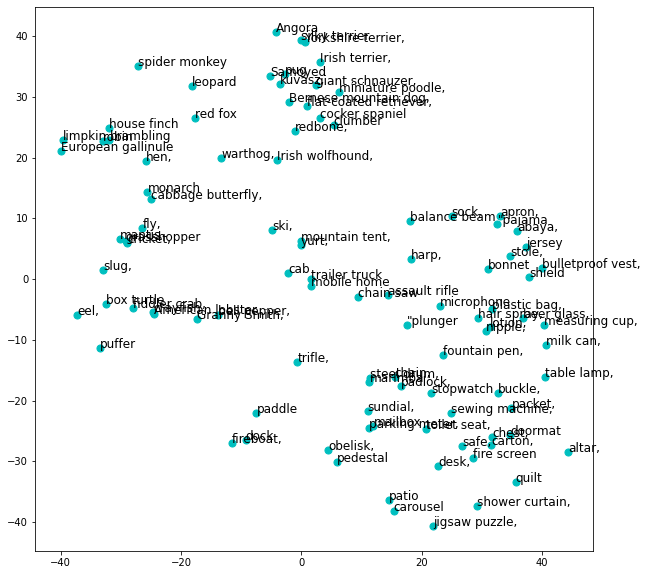

In [0]:
index = np.random.choice(np.arange(1000), size=100, replace=False)
z = class_tsne[index,0]
y = class_tsne[index,1]

fig, ax = plt.subplots(figsize=(10,10), facecolor='white')
plt.scatter(z, y, s=50, c='c')
for i, id in enumerate(index):
    ax.annotate(imagenet_id_to_label[str(id)], (z[i], y[i]), fontsize=12)

# Sample from BigGAN from a Given Class ID



In [0]:
#To sample from generator
def generate_sample(G, batch_size, class_label):
  G.eval()
  with torch.no_grad():
    z = torch.randn(batch_size, G.dim_z).to(DEVICE)
    y = torch.tensor(class_label).to(DEVICE)*torch.ones((batch_size,)).to(DEVICE).long()
    y_emb = G.shared(y)
    images = G(z, y_emb)
  return images

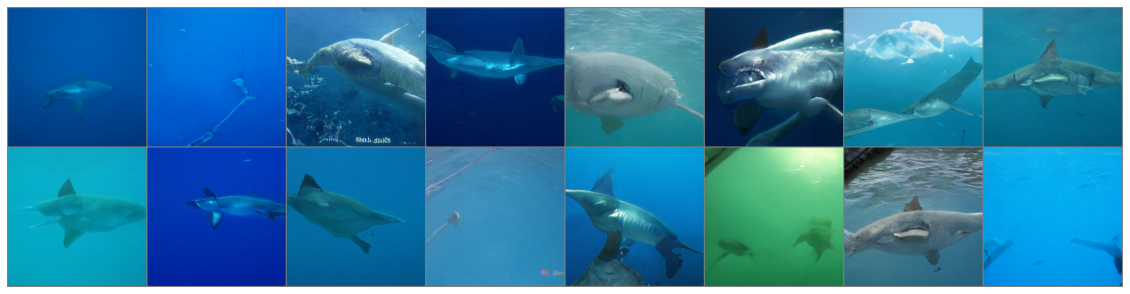

In [0]:
batch_size = 1
class_label = 2
img_list = []
for i in range(16):
  img = generate_sample(G, batch_size, class_label)
  img_list.append(img)
img_list = torch.cat(img_list, dim=0)
imshow(img_list)

# Linear Interpolation Samples

In [0]:
#Linear interpolation between two class embedings
def generate_linear_interpolate_sample(G, batch_size, class_label1, class_label2, alpha):
  G.eval()
  G.to(DEVICE)
  with torch.no_grad():
    z = torch.randn(batch_size, G.dim_z).to(DEVICE)
    class1_emb = G.shared(torch.tensor(class_label1).to(DEVICE)*torch.ones((batch_size,)).to(DEVICE).long())
    class2_emb = G.shared(torch.tensor(class_label2).to(DEVICE)*torch.ones((batch_size,)).to(DEVICE).long())

    ###########################################
    ##   FILL THIS IN: CREATE NEW EMBEDDING  ##
    ###########################################    
    new_emb = alpha*class1_emb + (1-alpha)*class2_emb

    images = G(z, new_emb)
  return images

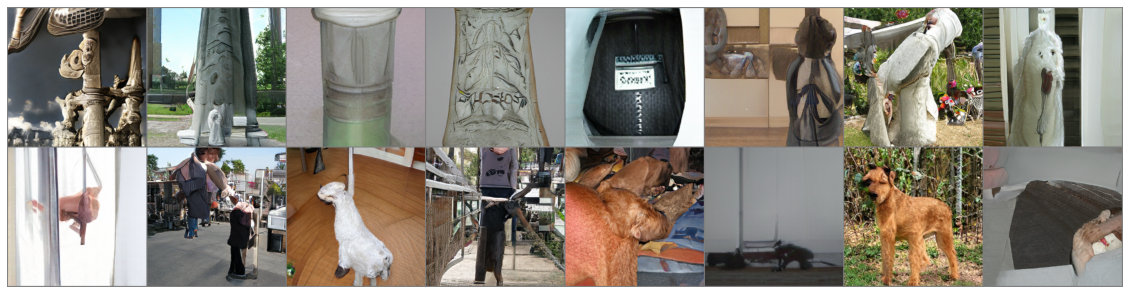

In [0]:
batch_size = 1
class_label_1 = 184
class_label_2 = 708

img_list = []
n = 16
for i in range(n):
  img = generate_linear_interpolate_sample(G, batch_size, class_label_1, class_label_2, i*(1/n))
  img_list.append(img)
img_list = torch.cat(img_list, dim=0)
imshow(img_list)